# Capital Bikeshare 共享单车数据预测——线性回归分析

## 1、导入必要的工具包

In [45]:
import numpy as np # 矩阵运算
import pandas as pd # 数据处理

from sklearn.metrics import r2_score  #评价回归预测模型的性能
from sklearn.utils import shuffle  

import matplotlib.pyplot as plt # 可视化
import seaborn as sns # 可视化

#图形出现在代码下方，不是新建窗口
%matplotlib inline 

## 2、数据探索

在另一个文件中已经做了数据探索，此处直接进行下一步

## 3、数据准备

In [46]:
#使用pandas读取.csv格式数据
data_raw = pd.read_csv("Bike-Sharing-Dataset/day.csv")
data_raw.shape

(731, 16)

## 4、数据预处理/特征工程

## 4.1移除部分无用特征并分割数据集

根据对数据探索和分析，先将原始数据中不需要的特征进行移除,此处总共去除了5个属性，年份属性也需要移除，但下方还需要根据年份属性分割测试集和训练集，故先保留

In [47]:
#移除目录号
data_drop_instant = data_raw.drop('instant', axis = 1)
#移除日期
data_drop_dteday = data_drop_instant.drop('dteday', axis = 1)
#移除注册用户数
data_drop_casual = data_drop_dteday.drop('casual', axis = 1)
#移除非注册用户数
data_drop_registered = data_drop_casual.drop('registered', axis = 1)
#由于气温和体感温度线性相关系数为1，强相关，故剔除其中一个
data_drop_temp = data_drop_registered.drop('temp', axis = 1)

data = data_drop_temp
data.shape




(731, 11)

将移除过无用特征得到的数据进行训练集和测试集的分离，此处根据年份将2011年的数据指定为训练集，将2012年的数据指定为测试集，然后再分别移除年份属性

In [48]:
data_train0 = data[data.yr==0]
data_test0 = data[data.yr==1]

data_train0.shape
#data_test0.shape

(365, 11)

In [49]:
#移除年份
data_train = data_train0.drop('yr', axis = 1)
data_test = data_test0.drop('yr', axis = 1)

data_train.shape
#data_test.shape

(365, 10)

## 4.2数据预处理 / 特征工程

### 4.2.1去除离群点

由数据分析可以得到，训练集中的部分特征存在离群点，若不去除，可能会影响最后的预测值与真值残差的分布，即预测的准确性。而测试集中的数据只用于最终测试，不应该去除样本数据。阈值大小可通过散点图和直方图估计出来

In [50]:
#去除属性 cnt 中大于5700的样本数据
data_train = data_train[data_train.cnt < 5700]
#去除属性 hum 中小于0.25的样本数据
data_train = data_train[data_train.hum > 0.25]
#去除属性 windspeed 中大于0.4的样本数据
data_train = data_train[data_train.windspeed < 0.4]

data_train.shape

(357, 10)

### 4.2.2打乱训练集

为了增加数据的随机性，需要把训练集数据打乱，测试集理论上不应该进行数据处理，而且不参与训练，故不进行打乱

In [51]:
data_train.head()

,season,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,1,1,0,6,0,2,0.363625,0.805833,0.160446,985
1,1,1,0,0,0,2,0.353739,0.696087,0.248539,801
2,1,1,0,1,1,1,0.189405,0.437273,0.248309,1349
3,1,1,0,2,1,1,0.212122,0.590435,0.160296,1562
4,1,1,0,3,1,1,0.229270,0.436957,0.186900,1600


In [52]:
data_train=shuffle(data_train)
data_train.shape

(357, 10)

In [53]:
#检验一下数据是否已经被打乱
data_train.head()

,season,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
225,3,8,0,0,0,2,0.624388,0.817500,0.222633,3820
154,2,6,0,6,0,1,0.594696,0.456250,0.123142,5342
147,2,5,0,6,0,1,0.612379,0.729583,0.230092,4758
148,2,5,0,0,0,1,0.615550,0.818750,0.213938,4788
163,2,6,0,1,1,1,0.601654,0.494583,0.305350,5020


### 4.2.3拆分输入特征和输出真值

将训练集和测试集分别拆分为输入特征 X 和输出真值 y

预期结果：
X_train （357，9）；
y_train （357，1）；
X_test （366，9）；
y_test （366，1）；

In [54]:
y_train = data_train['cnt'].values
X_train = data_train.drop('cnt', axis = 1)

#用于后续显示权重系数对应的特征
columns = X_train.columns

y_test = data_test['cnt'].values
X_test = data_test.drop('cnt', axis = 1)

X_train.shape
#X_test.shape

(357, 9)

### 4.2.4标准化处理

从数据探索可以看出，数据的每个特征取值区间差异比较大，故需要进行数据标准化预处理，即减去均值再除以方差

对原始特征进行标准化，可以降低每个特征的取值范围差异，保证每个维度的特征数据方差为1，均值为0,从而使训练得到的权重各系数差异降低，使得预测结果不会被某些维度过大的特征值而主导,而且后续还可通过系数来衡量各特征的重要性

In [55]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

#对y标准化的好处是不同问题的w差异不太大，同时正则参数的范围也有限
y_train = ss_y.fit_transform(y_train.reshape(-1, 1))
y_test = ss_y.transform(y_test.reshape(-1, 1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# 5、确定模型类型

## 5.1尝试缺省参数的线性回归

In [56]:
# 线性回归
#class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
from sklearn.linear_model import LinearRegression

# 使用默认配置初始化
lr = LinearRegression()

# 训练模型参数
lr.fit(X_train, y_train)

# 使用训练好的模型分别对训练集和测试集进行预测
y_test_pred_lr = lr.predict(X_test)
y_train_pred_lr = lr.predict(X_train)

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
coef_list = lr.coef_.T
coef_abs_list = map(abs, coef_list)
fs = pd.DataFrame({"columns":list(columns), "abs_coef":list(coef_abs_list)})
fs.sort_values(by=['abs_coef'],ascending=False)

,abs_coef,columns
6,[0.6444774183345154],atemp
0,[0.2932870174143726],season
5,[0.19883735613055464],weathersit
8,[0.09730252159431736],windspeed
7,[0.09249631254573863],hum
2,[0.05380930040104529],holiday
3,[0.03036364260009024],weekday
4,[0.013813330209271746],workingday
1,[0.009025595984837709],mnth


数据预处理之后就可以送进模型里面了。线性回归中使用其默认的参数配置，其中选择不做正规化处理的原因是因为已经提前将数据进行标准化了。因为数据集比较小，所以不设置并行处理

在训练完获得模型参数后，利用此模型分别对训练集和测试集进行预测，并将训练好的模型各系数列出来，查看各特征对预测结果的贡献程度，此处取了系数的绝对值，绝对值越大，表明此系数对应的特征对预测结果影响越大

可以看出体感温度对预测结果影响很大，很重要，而月份和工作日特征对结果影响非常小，在L1正则的时候可能该特征会被舍弃掉

In [57]:
# 使用r2_score评价模型在测试集和训练集上的性能，并输出评估结果
#测试集
print ('The r2 score of LinearRegression on test is', r2_score(y_test, y_test_pred_lr))
#训练集
print ('The r2 score of LinearRegression on train is', r2_score(y_train, y_train_pred_lr))

The r2 score of LinearRegression on test is -0.7058098049719741
The r2 score of LinearRegression on train is 0.7598525446307836


分别用r2_score来评价模型在测试集和训练集的性能，可以发现：

r2_score在训练集中得分较高，说明模型在训练集上的预测效果还行，但在测试集中得分为负，(表示很震惊啊(ΩДΩ)），不过r2_score的定义是（1 - 预测值与真值的差异 / 真值之间的差异），得到负值说明预测值与真值的差异比真值之间的差异大很多，从前期的数据分析可以看出，测试集的真值大致是正态分布，但数值的大小整体上比训练集的真值大很多，所以目前情况是：

1、测试集的真值比训练集的真值大很多，且数据的分布形状不同

2、训练使用的特征，如季节、月份、假日、星期几、工作日、天气等特征，在训练集和测试集中基本是一样的（我自己分别做了直方图进行对比，但在数据分析里面只体现了训练集的），湿度有些差别。。。

所以，特征差不多，使用的模型一样，测试集的预测结果应该和训练集的真值比较接近，但由于第一条的原因，造成了预测结果和测试真值差别很大

猜测原因有两种可能：1、2011年或2012年其中一年的数据真值有问题； 2、数据中列出的大多数特征可能对预测结果并没有太大影响，而根据数据分析，注册用户数和租车人数相关性很强，但是作业要求将唯一强相关的特征 注册用户数 剔除了，造成模型没训练好； 3、可能是造成2011年和2012年租车人数不同的一些特征没被作为调查项被包含在数据集中，如2012年时提倡绿色出行造成了相同条件下租车人数增多等等

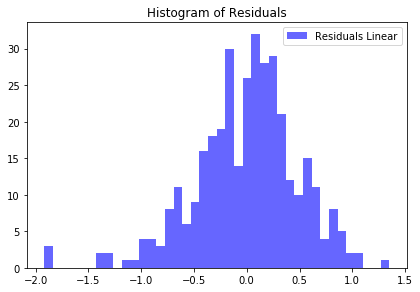

In [58]:
#在训练集上观察预测残差的分布，看是否符合模型假设：噪声为0均值的高斯噪声
f, ax = plt.subplots(figsize=(6, 4)) 
f.tight_layout() 
ax.hist(y_train - y_train_pred_lr,bins=40, label='Residuals Linear', color='b', alpha=.6); 
ax.set_title("Histogram of Residuals") 
ax.legend(loc='best');

上图是在训练集上的预测残差分布，整体还是有点像均值为0的正态分布的，说明模型训练的还行，但是在0均值附近有一列凹进去的地方，说明预测值约等于真值的有一部分数据丢失了，之前去除了一些离群点，尝试把离群点加回去，发现凹进去的地方有所缓和，说明移除的离群点对模型的训练是有影响的，可能是因为我去除的离群点属于连续型的特征，个人认为连续型的特征（如湿度、风度等）与结果的相关性比类别型特征（如月份、星期几）与结果的相关性大一点，可能离群点去除的有点多了。另一方面，也有可能是因为样本数据太少了，总共只有350个左右样本，还不足以训练出一个较稳定的模型

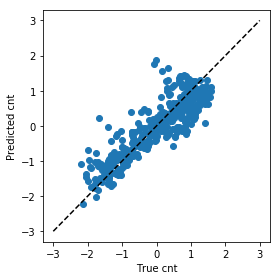

In [59]:
#预测值与真值的散点图
plt.figure(figsize=(4, 4))
plt.scatter(y_train, y_train_pred_lr)
plt.plot([-3, 3], [-3, 3], '--k')   #数据已经标准化，3倍标准差即可
plt.axis('tight')
plt.xlabel('True cnt')
plt.ylabel('Predicted cnt')
plt.tight_layout()

基本上预测值和真值属于线性相关的，而且由于剔除了一些离群点，散点图上没有偏离的很离谱的点，说明预测的还行

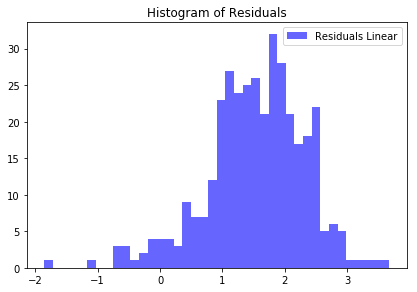

In [60]:
#在测试集上观察预测残差的分布，看是否符合模型假设：噪声为0均值的高斯噪声
f, ax = plt.subplots(figsize=(6, 4)) 
f.tight_layout() 
ax.hist(y_test - y_test_pred_lr,bins=40, label='Residuals Linear', color='b', alpha=.6); 
ax.set_title("Histogram of Residuals") 
ax.legend(loc='best');

进一步画出测试集的预测值和真值的残差分布，发现基本符合高斯分布的形状，但上面的r2_score的评分是负数，所以验证了猜想：训练集和测试集的特征是高度相似的，训练集训练出来的模型在测试集上也能使残差成正态分布，但是由于测试集的真值整体比训练集有明显的增大，造成了测试集的预测值与真值的差异

In [61]:
# 线性模型，随机梯度下降优化模型参数
from sklearn.linear_model import SGDRegressor

# 使用默认配置初始化线
sgdr = SGDRegressor(max_iter=1000)

# 训练：参数估计
sgdr.fit(X_train, y_train)

# 预测
#sgdr_y_predict = sgdr.predict(X_test)

sgdr.coef_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 0.29344215,  0.00914217, -0.05366267,  0.03006426,  0.01353414,
       -0.19898028,  0.64422447, -0.09221089, -0.09760748])

随机梯度下降法适用于大型训练集，因为在做反向传播的时候要计算每个维度的梯度，如果样本数非常多，每次迭代的花费的时间很长，整体训练时间和计算量都会加大，使用SGD一方面可以降低计算量，更快的收敛，另一方面也可以增加随机性，更可能跳出局部最优解，找到全局最优解。本题的数据量非常小，使用随机梯度下降法可能训练效果反而变差

In [62]:
# 使用SGDRegressor模型自带的评估模块(评价准则为r2_score)，并输出评估结果
print ('The value of default measurement of SGDRegressor on test is', sgdr.score(X_test, y_test))
print ('The value of default measurement of SGDRegressor on train is', sgdr.score(X_train, y_train))

The value of default measurement of SGDRegressor on test is -0.7059382463912496
The value of default measurement of SGDRegressor on train is 0.759852002000119


## 5.2正则化的线性回归（L2正则 --> 岭回归）

In [63]:
#岭回归／L2正则
#class sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, 
#                                  normalize=False, scoring=None, cv=None, gcv_mode=None, 
#                                  store_cv_values=False)
from sklearn.linear_model import  RidgeCV

#设置超参数（正则参数）范围
alphas = [ 0.01, 0.1, 1, 10,100]
#n_alphas = 20
#alphas = np.logspace(-5,2,n_alphas)

#生成一个RidgeCV实例
ridge = RidgeCV(alphas=alphas, store_cv_values=True)  

#模型训练
ridge.fit(X_train, y_train)    

#预测
y_test_pred_ridge = ridge.predict(X_test)
y_train_pred_ridge = ridge.predict(X_train)


# 评估，使用r2_score评价模型在测试集和训练集上的性能
print ('The r2 score of RidgeCV on test is', r2_score(y_test, y_test_pred_ridge))
print ('The r2 score of RidgeCV on train is', r2_score(y_train, y_train_pred_ridge))

The r2 score of RidgeCV on test is -0.717885446567879
The r2 score of RidgeCV on train is 0.7594162834790815


RodgeCV中已经封装了交叉验证，默认参数使用mse来评价交叉验证，使用留一交叉验证的方式，由于要打印出结果，所以参数中选择了保留结果。alpha是用来约束模型复杂度的一个超参数，训练时一般在log域中均匀取值，此处取五个值。最后得出的r2_score在训练集上的分数比上方没有正则项的线性回归小0.00044左右，说明第一个训练方法有轻微的过拟合

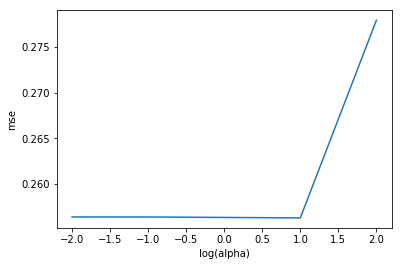

alpha is: 10.0


,coef_lr,coef_ridge,columns
6,[0.6444774183345154],[0.6275083240477665],atemp
0,[0.2932870174143726],[0.2769855493322594],season
3,[0.03036364260009024],[0.028434783389145735],weekday
4,[0.013813330209271746],[0.014400902854231179],workingday
1,[0.009025595984837709],[0.02629649912611577],mnth
2,[-0.05380930040104529],[-0.053623816058115725],holiday
7,[-0.09249631254573863],[-0.08847349501436463],hum
8,[-0.09730252159431736],[-0.09601170470478232],windspeed
5,[-0.19883735613055464],[-0.1971687824316214],weathersit


In [64]:
mse_mean = np.mean(ridge.cv_values_, axis = 0)
plt.plot(np.log10(alphas), mse_mean.reshape(len(alphas),1)) 

plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()

print ('alpha is:', ridge.alpha_)

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef_lr":list((lr.coef_.T)), "coef_ridge":list((ridge.coef_.T))})
fs.sort_values(by=['coef_lr'],ascending=False)

上面选用不同的alpha作为超参数，使用交叉验证的方式分别算出每个alpha对应训练出来的模型各系数的均值，可以发现最佳的alpha是10，使用正则项对模型进行约束后，表中基本所有的系数相比于无正则项的系数都有所收缩，个别除外

## 5.3 正则化的线性回归（L1正则 --> Lasso）

In [65]:
#### Lasso／L1正则
# class sklearn.linear_model.LassoCV(eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, 
#                                    normalize=False, precompute=’auto’, max_iter=1000, 
#                                    tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=1,
#                                    positive=False, random_state=None, selection=’cyclic’)
from sklearn.linear_model import LassoCV

#设置超参数搜索范围
#alphas = [ 0.01, 0.1, 1, 10,100]

#生成一个LassoCV实例
#lasso = LassoCV(alphas=alphas)  
lasso = LassoCV()  

#训练（内含CV）
lasso.fit(X_train, y_train)  

#测试
y_test_pred_lasso = lasso.predict(X_test)
y_train_pred_lasso = lasso.predict(X_train)


# 评估，使用r2_score评价模型在测试集和训练集上的性能
print ('The r2 score of LassoCV on test is', r2_score(y_test, y_test_pred_lasso))
print ('The r2 score of LassoCV on train is', r2_score(y_train, y_train_pred_lasso))

The r2 score of LassoCV on test is -0.7120505126908245
The r2 score of LassoCV on train is 0.7597376967780604


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


L1正则具有稀疏作用，当alpha值越大，正负alpha的区间越大，惩罚越狠，也会有更多的系数变为0，这里可以使用默认参数，即设置alpha的最大值与最小值的比值为0.001，在这个区间再分为100个均匀的alpha进行计算。迭代条件使用默认，可以发现lasso的r2socre评分比岭回归的稍微差一点，并不是说lasso模型不如岭回归，而是不用的数据集适用不同的模型

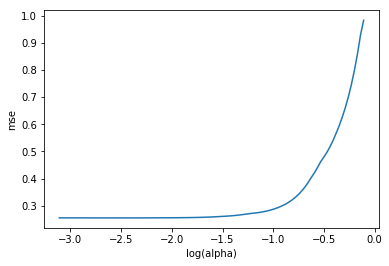

alpha is: 0.004151794259440714


,coef_lasso,coef_lr,coef_ridge,columns
6,0.641265,[0.6444774183345154],[0.6275083240477665],atemp
0,0.292394,[0.2932870174143726],[0.2769855493322594],season
3,0.026580,[0.03036364260009024],[0.028434783389145735],weekday
4,0.010461,[0.013813330209271746],[0.014400902854231179],workingday
1,0.006054,[0.009025595984837709],[0.02629649912611577],mnth
2,-0.050648,[-0.05380930040104529],[-0.053623816058115725],holiday
7,-0.086233,[-0.09249631254573863],[-0.08847349501436463],hum
8,-0.093276,[-0.09730252159431736],[-0.09601170470478232],windspeed
5,-0.198828,[-0.19883735613055464],[-0.1971687824316214],weathersit


In [66]:
mses = np.mean(lasso.mse_path_, axis = 1)
plt.plot(np.log10(lasso.alphas_), mses) 
#plt.plot(np.log10(lasso.alphas_)*np.ones(3), [0.3, 0.4, 1.0])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()    
            
print ('alpha is:', lasso.alpha_)

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef_lr":list((lr.coef_.T)), "coef_ridge":list((ridge.coef_.T)), "coef_lasso":list((lasso.coef_.T))})
fs.sort_values(by=['coef_lr'],ascending=False)

可以看出，alpha的最佳值是 0.01927092187407769，相对较大，所以对模型有一定惩罚作用，如工作日和月份两个特征的的系数就变成0了，所以lasso的训练结果认为这两个特征对结果的预测贡献度不大，验证了上方最小二乘线性回归的猜测，后续可以考虑将这两个特征移除，再训练一次岭回归模型，看看预测效果